In [1]:
!pip install category_encoders

In [26]:
!pip install scikit-learn --upgrade

  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [2]:
# Import packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import time
from tqdm import tqdm, trange
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer

from category_encoders import TargetEncoder
from kernels import rbf_kernel, ard_kernel
from model import DynamicGPR

## Data Introduction

### Read Data

Variabel Target: DepDelay

Target yang dicapai:
* Waktu yang bisa dipilih sehingga DepDelaynya minimal


In [2]:
# Import Data
df = pd.read_csv('2008 (1).csv')

In [3]:
# Informasi Fitur
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2389217 entries, 0 to 2389216
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       float64
 25  WeatherDelay      

Data ini terdiri dari 2 juta baris dan 28 fitur 

### Missing Values Treatment

Tinjau nilai kosong pada setiap fitur

In [4]:
# Lihat jumlah missing values
df.isnull().sum()

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime                64442
CRSDepTime                 0
ArrTime                70096
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
TailNum                42452
ActualElapsedTime      70096
CRSElapsedTime           407
AirTime                70096
ArrDelay               70096
DepDelay               64442
Origin                     0
Dest                       0
Distance                   0
TaxiIn                 70096
TaxiOut                64442
Cancelled                  0
CancellationCode     2324775
Diverted                   0
CarrierDelay         1804634
WeatherDelay         1804634
NASDelay             1804634
SecurityDelay        1804634
LateAircraftDelay    1804634
dtype: int64

Karena kita ingin memprediksi variabel Departure Delay, maka untuk dapat memvalidasi performa model, nilai kosong pada DepDelay akan dibuang

Lalu, informasi pada ArrTime tidak dapat diisi karena tidak cukup informasi yang ada di data tersebut, oleh karena itu drop nilai kosong pada variabel ArrTime

In [5]:
# Drop null values on DepDelay variable
df.dropna(subset = ['DepDelay'], inplace = True)

# Drop null values at ArrTime variable
df.dropna(subset = ['ArrTime'], inplace = True)

In [6]:
# Cek jumlah null valuesnya lagi
df.isnull().sum()

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime                    0
CRSDepTime                 0
ArrTime                    0
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
TailNum                    2
ActualElapsedTime          0
CRSElapsedTime             0
AirTime                    0
ArrDelay                   0
DepDelay                   0
Origin                     0
Dest                       0
Distance                   0
TaxiIn                     0
TaxiOut                    0
Cancelled                  0
CancellationCode     2319121
Diverted                   0
CarrierDelay         1734538
WeatherDelay         1734538
NASDelay             1734538
SecurityDelay        1734538
LateAircraftDelay    1734538
dtype: int64

Dari dokumentasi datanya, nilai NA pada variabel CarrierDelay, WeatherDelay, NASDelay, dstnya disebabkan oleh salah satu variabel di antaranya telah diisi suatu nilai

Jadi nilai kosong pada observasi tersebut disebabkan karena tidak ada delay yang bersangkutan, dengan demikian isi nilai kosong pada variabel tersebut dengan 0

In [7]:
# Isi nilai kosong dengan 0
values = {"CarrierDelay": 0, "WeatherDelay": 0, "NASDelay": 0, 
          "SecurityDelay": 0, "LateAircraftDelay": 0}
df.fillna(value = values, inplace = True)

In [9]:
# Lihat jumlah missing values
df.isnull().sum()

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime                    0
CRSDepTime                 0
ArrTime                    0
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
TailNum                    2
ActualElapsedTime          0
CRSElapsedTime             0
AirTime                    0
ArrDelay                   0
DepDelay                   0
Origin                     0
Dest                       0
Distance                   0
TaxiIn                     0
TaxiOut                    0
Cancelled                  0
CancellationCode     2319121
Diverted                   0
CarrierDelay               0
WeatherDelay               0
NASDelay                   0
SecurityDelay              0
LateAircraftDelay          0
dtype: int64

Selain itu, drop informasi ArrTime, DepTime, ActualElapsedTime, asumsikan dalam kasus ini kita tidak mengetahui waktu keberangkatan dan kedatangan secara aktual, kita hanya mengetahui ArrTime, DepTime, dan ActualElapsedTime berdasarkan jadwalnya saja.Lalu, cek summary statistics dari setiap fitur numerik

In [10]:
df.describe()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,...,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,2319121.0,2.319121e+06,2.319121e+06,2.319121e+06,2.319121e+06,2.319121e+06,2.319121e+06,2.319121e+06,2.319121e+06,2.319121e+06,...,2.319121e+06,2.319121e+06,2.319121e+06,2319121.0,2319121.0,2.319121e+06,2.319121e+06,2.319121e+06,2.319121e+06,2.319121e+06
mean,2008.0,2.510822e+00,1.569614e+01,3.915918e+00,1.340110e+03,1.329276e+03,1.485835e+03,1.495850e+03,2.193090e+03,1.286189e+02,...,7.298122e+02,6.839862e+00,1.667740e+01,0.0,0.0,3.970863e+00,7.406457e-01,4.073079e+00,2.028139e-02,5.287619e+00
std,0.0,1.123481e+00,8.744867e+00,1.982641e+00,4.802425e+02,4.660631e+02,5.081295e+02,4.848133e+02,1.942081e+03,7.025303e+01,...,5.591559e+02,4.846435e+00,1.101203e+01,0.0,0.0,2.123238e+01,9.707138e+00,1.685939e+01,8.755874e-01,2.142118e+01
min,2008.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.400000e+01,...,2.400000e+01,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2008.0,1.000000e+00,8.000000e+00,2.000000e+00,9.300000e+02,9.250000e+02,1.110000e+03,1.115000e+03,5.960000e+02,7.800000e+01,...,3.280000e+02,4.000000e+00,1.000000e+01,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2008.0,3.000000e+00,1.600000e+01,4.000000e+00,1.331000e+03,1.322000e+03,1.516000e+03,1.519000e+03,1.529000e+03,1.110000e+02,...,5.850000e+02,6.000000e+00,1.400000e+01,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2008.0,4.000000e+00,2.300000e+01,6.000000e+00,1.733000e+03,1.720000e+03,1.914000e+03,1.910000e+03,3.574000e+03,1.600000e+02,...,9.640000e+02,8.000000e+00,1.900000e+01,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2008.0,4.000000e+00,3.100000e+01,7.000000e+00,2.400000e+03,2.359000e+03,2.400000e+03,2.359000e+03,9.740000e+03,9.050000e+02,...,4.962000e+03,2.130000e+02,3.830000e+02,0.0,0.0,2.436000e+03,1.148000e+03,1.357000e+03,3.920000e+02,1.254000e+03


Perhatikan bahwa fitur Cancelled dan Diverted kini hanya bernilai 0, karena variansinya 0, drop juga kedua fitur tersebut

In [11]:
# Drop fitur 
df.drop(['ArrTime','DepTime','ActualElapsedTime',
        'Cancelled','Diverted'], axis = 1, inplace = True)

### EDA

#### DepDelay
Untuk melihat berapa lama waktu Departure Delay dari setiap tanggal, akan dibuat fitur date yang berisi informasi tanggal pada observasi yang bersangkutan

In [12]:
# Make Date
df['date'] = df[['DayofMonth','Month','Year']].apply(lambda date: str(date[2]) + '-' + str(date[1]) + '-' + str(date[0]), axis = 1)
df['date'] = pd.to_datetime(df['date'])

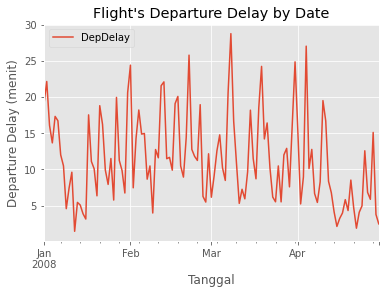

In [13]:
# Groupby Date
df.groupby(['date']).agg({'DepDelay':'mean'}).plot()
plt.title("Flight's Departure Delay by Date")
plt.ylabel('Departure Delay (menit)')
plt.xlabel('Tanggal')
plt.show()

Dari diagram di atas dapat dilihat bahwa departure delay terlama terjadi pada bulan Maret 2008

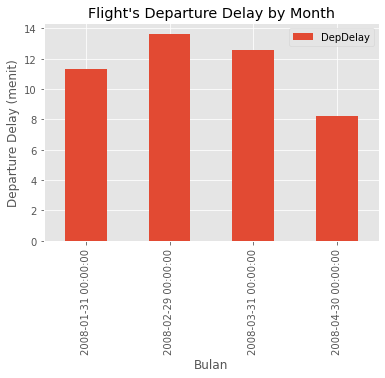

In [14]:
# Lihat per bulan
df.groupby(['date']).agg({'DepDelay':'mean'}).resample('M').mean().plot(kind = 'bar')
plt.title("Flight's Departure Delay by Month")
plt.ylabel('Departure Delay (menit)')
plt.xlabel('Bulan')
plt.show()

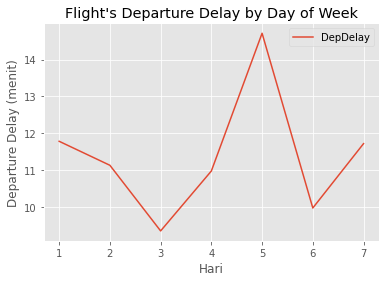

In [15]:
# Groupby DayofWeek
df.groupby(['DayOfWeek']).agg({'DepDelay':'mean'}).plot()
plt.title("Flight's Departure Delay by Day of Week")
plt.ylabel('Departure Delay (menit)')
plt.xlabel('Hari')
plt.show()

Asumsikan 1: Senin, 7: Minggu, berarti rerata waktu delay tertinggi ada di hari Jumat

### Cleaning Data


#### Splitting Data

In [59]:
# Split jadi data training dan test
train = df[df['Month'] < 4]
test = df[df['Month'] >= 4]

X_train = train.drop(['DepDelay'], axis = 1)
y_train = train['DepDelay']
X_test = test.drop(['DepDelay'], axis = 1)
y_test = test['DepDelay']

# Lihat jumlah observasi
print('Ukuran data training:', train.shape)
print('Ukuran data test:', test.shape)

Ukuran data training: (1732398, 25)
Ukuran data test: (586723, 25)


In [61]:
X_test[['Origin', 'Dest']]

,Origin,Dest
1791091,MAF,DAL
1791092,MAF,HOU
1791093,MAF,HOU
1791094,MAF,LAS
1791095,MCI,ABQ
...,...,...
2389212,BOS,CVG
2389213,CVG,BOS
2389214,BOS,CVG
2389215,CVG,BOS


In [62]:
# Drop Features
X_train.drop(['date','Year','FlightNum', 
              'UniqueCarrier','TailNum','CancellationCode'], axis = 1, inplace = True)

# Save Test ID
test_ID = X_test[['date','FlightNum', 'UniqueCarrier','TailNum', 'Origin', 'Dest']]
X_test.drop(['date','Year','FlightNum', 'UniqueCarrier','TailNum','CancellationCode'], axis = 1, inplace = True)

#### Encoding Categorical

Mari lihat distribusi data kategorikal pada fitur origin dan destinasi

In [22]:
# Lihat persebaran jumlah nilai kategori pada fitur origin
df['Origin'].value_counts()

ATL    133852
ORD    109196
DFW     88575
DEN     77025
LAX     72096
        ...  
RHI        27
PLN        26
TUP        10
DLG         2
AKN         2
Name: Origin, Length: 291, dtype: int64

In [23]:
# Lihat persebaran jumlah nilai kategori pada fitur Dest
df['Dest'].value_counts()

ATL    133521
ORD    108746
DFW     88146
DEN     77012
LAX     72079
        ...  
RHI        27
PLN        26
TUP         9
AKN         2
DLG         2
Name: Dest, Length: 291, dtype: int64

Karena jumlah kategori unik ada banyak untuk kedua fitur, maka digunakan Target Encoding untuk mengubah nilai kategori tersebut menjadi peluang posterior target diberikan nilai kategori tersebut

Untuk mencegah kebocoran informasi variabel target saat cross validation, maka target encoder akan digunakan pada saat proses validasi dan setelah validasi untuk seluruh data training

In [24]:
# Pilih semua fitur kategori
cat_columns = X_train.select_dtypes(include = ['object']).columns

# Target Encoding
te = TargetEncoder(cols=cat_columns)

In [25]:
cat_columns

Index(['Origin', 'Dest'], dtype='object')

### Scaling Data
Fitur numerik perlu diskalakan agar proses komputasi dapat berjalan lebih cepat dan terkontrol

In [26]:
# Initiate Scaler
scaler = StandardScaler()

# Fit on training data
scaler.fit(np.array(y_train).reshape(-1, 1))

# Fit transform on training data
y_train_scaled = scaler.transform(np.array(y_train).reshape(-1, 1))
y_test_scaled = scaler.transform(np.array(y_test).reshape(-1, 1))

In [27]:
# Pilih fitur numerik dari data
num_feats = X_train.select_dtypes(include = ['int','float']).columns
num_feats

Index(['Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime',
       'CRSElapsedTime', 'AirTime', 'ArrDelay', 'Distance', 'TaxiIn',
       'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay'],
      dtype='object')

In [28]:
# Using column transformer, fit StandardScaler
ct = ColumnTransformer([
        ('scaled', StandardScaler(), num_feats)
    ], remainder= 'passthrough')

## Model Prediction

### Make Validation Function

In [29]:
# Tracking progress
model_list = []
parameter = []
exec_time = []
mean_mse = []

In [30]:
def cross_val_model(model, model_params, X = X_train, y = y_train_scaled): 
    print(str(model).upper())
    print('--------------------')
    model_list.append(str(model))
    parameter.append(model_params)
    print(f'Parameter: {model_params}')

    # Initiate TSS and mse_scores
    tss = TimeSeriesSplit(n_splits=5)
    mse_scores = []

    # Cross validation
    start_time = time.time()
    for i, (train_index, test_index) in enumerate(tss.split(X, y)):
        print(f"Fold {i+1}:")
        # Filter the index
        X_train_subset = X.iloc[train_index, :]
        X_test_subset = X.iloc[test_index, :]
        y_train_subset = y[train_index]
        y_test_subset = y[test_index]

        # Fit Target Encoding
        X_train_te = te.fit_transform(X_train_subset, y_train_subset)
        X_test_te = te.transform(X_test_subset)
    
        # Using column transformer, fit StandardScaler
        # Scale
        X_train_te = pd.DataFrame(ct.fit_transform(X_train_te), 
                                  columns = ct.get_feature_names_out())
        X_test_te = pd.DataFrame(ct.transform(X_test_te), 
                                 columns = ct.get_feature_names_out())

        # Rename Columns
        X_train_te.columns = [col.split('__')[-1] for col in X_train_te.columns]
        X_test_te.columns = [col.split('__')[-1] for col in X_test_te.columns]

        # Change to numpy array
        X_train_te = np.array(X_train_te)
        X_test_te = np.array(X_test_te)

        # Fit the model
        model.fit(X_train_te, y_train_subset)

        # Predict
        y_pred, model_params = model.predict(X_test_te, 
                           return_var = False, 
                           center_cluster = False, 
                           eval_kernel = True)
        
        # Fit on training data
        scaler.fit(np.array(y_train).reshape(-1, 1))

        # Inverse Transform
        y_test_inv = scaler.inverse_transform(y_test_subset).flatten()
        y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        
        # Calculate the f1 score
        mse_score_scaled = mean_squared_error(y_test_subset, y_pred)
        mse_score_inversed = mean_squared_error(y_test_inv, y_pred_inv)
        
        # Print MSE
        print('MSE Score:', mse_score_scaled)
        print('MSE on inverse scale data:', mse_score_inversed)
        mse_scores.append(mse_score_inversed)
        
        # Plot prediction
        idx = [i for i in range(y_test_subset.shape[0])]
        plt.plot(idx, y_test_inv, label = 'Actual')
        plt.plot(idx, y_pred_inv, linestyle = '--', label = 'Prediction')
        plt.title(f"Fold {i+1} Prediction")
        plt.legend()
        plt.show()
        
        # Plot feature Importances
        features = X_test_subset.columns
        weight_features = model_params[:-1]
        sns.barplot(x = weight_features,
                    y = features,
                    color = 'green')
        plt.title(f'Dynamic GPR Feature Importances Fold {i+1}')
        plt.show()
        print('-------------------------------')
    
    end_time = time.time() - start_time
    exec_time.append(end_time)
    print(f'Time Execution: {end_time} s')

    # Print the average AUC score
    print('Average MSE:', np.mean(mse_scores))
    mean_mse.append(np.mean(mse_scores))
    return mse_scores

### 5 fold prediction


<MODEL.DYNAMICGPR OBJECT AT 0X000001B89F4BB880>
--------------------
Parameter: {'sigma_init': 10.0, 'weight_init': [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2], 'kernel': 'ARD', 'n_clusters': 10, 'learning_rate': 0.01, 'batch_size': 32}
Fold 1:


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
ML: 100%|██████████████████████████████████████████████████████████████████████████| 9023/9023 [06:19<00:00, 23.75it/s]


ARD Optimized
Optimized weight: [0.2, 0.22277518363119078, 0.5913582084227768, 0.3983829889830169, 0.3965352092691798, 0.23181155589901667, 0.23166669846353657, 0.2020310999202551, 0.23265596588122392, 0.2776306377757539, 0.2014825339755045, 0.20508542573644922, 0.20001078299027958, 0.20331492651246671, 0.2000115572261267, 0.20910659333792736, 0.20001017961129844, 0.200019506462662]
Optimized sigma signal: 12.885605470162108
MSE Score: 0.6591519490247274
MSE on inverse scale data: 933.7146989313338


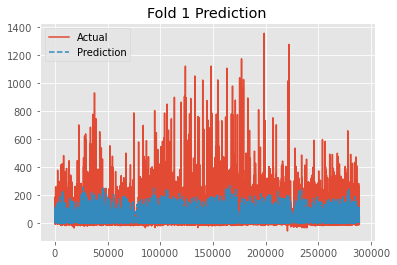

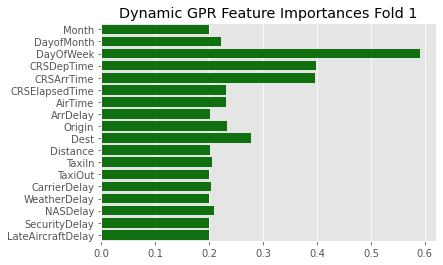

-------------------------------
Fold 2:


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
ML: 100%|████████████████████████████████████████████████████████████████████████| 18046/18046 [12:09<00:00, 24.74it/s]


ARD Optimized
Optimized weight: [0.2, 0.292981300244129, 0.7763101813427257, 0.5036129944858009, 0.5057841879567317, 0.431616895941467, 0.43038060904611425, 0.20344596595658984, 0.4291334913651281, 0.2838662384839269, 0.2044966162398043, 0.20892667692604094, 0.20002042550224064, 0.20708230873309882, 0.2000163946351335, 0.21748494198821042, 0.20005115672075383, 0.20003349696557526]
Optimized sigma signal: 16.481704450115146
MSE Score: 0.6851337442019759
MSE on inverse scale data: 970.5189351890202


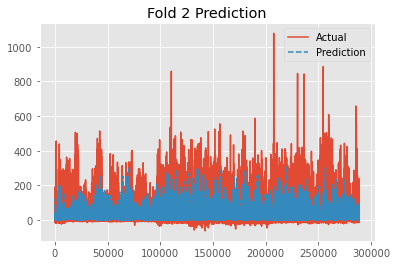

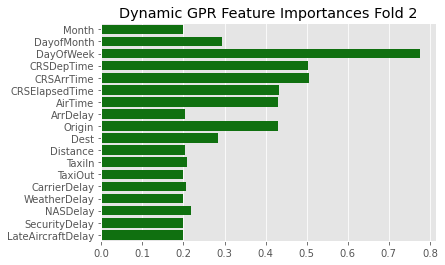

-------------------------------
Fold 3:


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
ML: 100%|████████████████████████████████████████████████████████████████████████| 27069/27069 [18:00<00:00, 25.06it/s]


ARD Optimized
Optimized weight: [0.5349152358526353, 0.6449499625290747, 0.7773596235264845, 0.5573512643661261, 0.5583067442523862, 0.4335333025938064, 0.4320785834418508, 0.20821929230523883, 0.43083759320844056, 0.3195988736221618, 0.20722640313582094, 0.2117303562864154, 0.20003668318162585, 0.2149408345245364, 0.20002058068865752, 0.22514124523757426, 0.20005541791029857, 0.20004514864949108]
Optimized sigma signal: 20.03565159437542
MSE Score: 0.943430803407164
MSE on inverse scale data: 1336.4068935383225


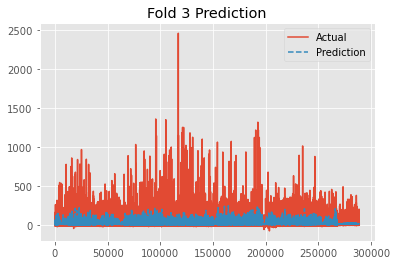

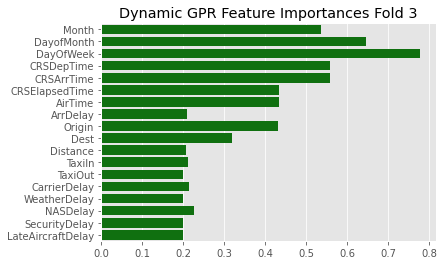

-------------------------------
Fold 4:


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
ML: 100%|████████████████████████████████████████████████████████████████████████| 36092/36092 [23:20<00:00, 25.77it/s]


ARD Optimized
Optimized weight: [0.5420287658939639, 0.7636667724955871, 0.7834564659083503, 0.5979861430403836, 0.6019547868375388, 0.5108218153112286, 0.5092876201814692, 0.20825473018979196, 0.5066361773611177, 0.3466461108037968, 0.21085724017447283, 0.21293101854177365, 0.20004244178962546, 0.22329966565750609, 0.20002228156243007, 0.22864663232873433, 0.20005681278961096, 0.2000522817372614]
Optimized sigma signal: 23.361098470972166
MSE Score: 0.7764148536263542
MSE on inverse scale data: 1099.8222221328083


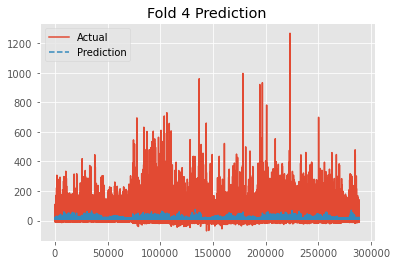

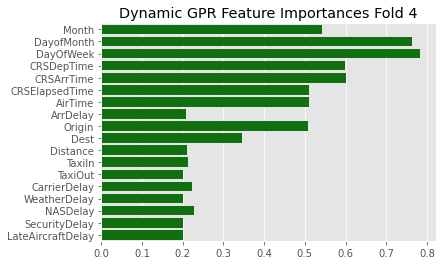

-------------------------------
Fold 5:


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
ML: 100%|████████████████████████████████████████████████████████████████████████| 45115/45115 [25:08<00:00, 29.90it/s]


ARD Optimized
Optimized weight: [0.6829729079073401, 0.772027056305163, 0.8711406699646674, 0.6259295944403082, 0.6312261180488633, 0.5529112182246876, 0.5514566746819712, 0.20876305238868376, 0.5483141127286766, 0.3502329539691504, 0.21319675237842103, 0.2160595325945033, 0.2005685399006586, 0.22632580441686792, 0.2000243631916593, 0.23482028276847816, 0.2000588592288093, 0.20005515891637426]
Optimized sigma signal: 26.653789294350023
MSE Score: 1.0231363146060775
MSE on inverse scale data: 1449.3128896479845


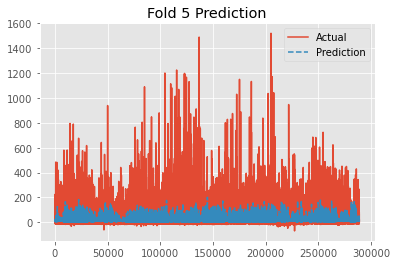

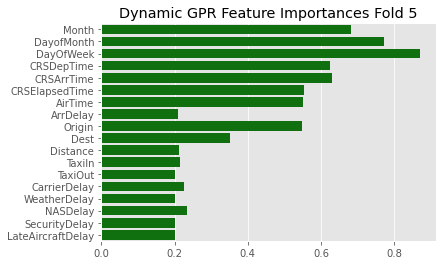

-------------------------------
Time Execution: 5980.95906329155 s
Average MSE: 1157.955127887894


In [29]:
# Initiate Parameters
l_init = None
sigma_init = 10.0
weight_init = [0.2 for i in range(len(X_train.columns))]
kernel_type = 'ARD'
n_clusters = 10
learning_rate = 1e-2
batch_size = 32

params = {'sigma_init': sigma_init,
          'weight_init': weight_init,
          'kernel': 'ARD',
          'n_clusters': n_clusters,
          'learning_rate': learning_rate,
          'batch_size': batch_size}

gpr = DynamicGPR(l_init = l_init,
                 sigma_init = sigma_init,
                 weight_init = weight_init,
                 n_clusters = n_clusters,
                 kernel = kernel_type,
                 learning_rate = learning_rate,
                 batch_size = batch_size)

# Fit Model
gpr_1_mse_scores = cross_val_model(gpr, model_params = params)

### Test Prediction

In [31]:
# Encode categorical data
X_train_te = te.fit_transform(X_train, y_train)
X_test_te = te.transform(X_test)

# Using column transformer, fit StandardScaler
ct = ColumnTransformer([
        ('scaled', StandardScaler(), num_feats)
    ], remainder= 'passthrough')

# Scale
X_train_scaled = pd.DataFrame(ct.fit_transform(X_train_te), 
                              columns = ct.get_feature_names_out())
X_test_scaled = pd.DataFrame(ct.transform(X_test_te), 
                             columns = ct.get_feature_names_out())
# Rename Column
X_train_scaled.columns = [col.split('__')[-1] for col in X_train_scaled.columns]
X_test_scaled.columns = [col.split('__')[-1] for col in X_test_scaled.columns]

# Transform to numpy array
X_train_scaled_mat = np.array(X_train_scaled)
X_test_scaled_mat = np.array(X_test_scaled)

In [33]:
# Initiate Parameters
l_init = None
sigma_init = 10.0
weight_init = [0.2 for i in range(len(X_train.columns))]
kernel_type = 'ARD'
n_clusters = 10
learning_rate = 1e-2
batch_size = 32

# Initiate Model
gpr = DynamicGPR(l_init = l_init,
                 sigma_init = sigma_init,
                 weight_init = weight_init,
                 n_clusters = n_clusters,
                 kernel = kernel_type,
                 learning_rate = learning_rate,
                 batch_size = batch_size)

# Fit the model
gpr.fit(X_train_scaled_mat, y_train_scaled)

C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
ML: 100%|██████████| 54138/54138 [31:51<00:00, 28.33it/s] 


In [34]:
# Predict
y_pred, params = gpr.predict(X_test_scaled_mat, 
                       return_var = False, 
                       center_cluster = False, 
                       eval_kernel = True)

ARD Optimized
Optimized weight: [0.19983233309107076, 0.19992270235540754, 0.2000138329603557, 0.19809690932773397, 0.19832393381466262, 0.32137172848695467, 0.322271287933011, 0.007691722958900063, 0.3197856173977669, 0.20100546374385525, 0.1917904843204062, 0.14464887401795976, 0.16827963276567331, 0.18164556206093324, 0.20000112748770385, 0.0670093997384967, 0.41635980819682694, 0.3924221061031561]
Optimized sigma signal: 19.248195634807562


### Model Inference

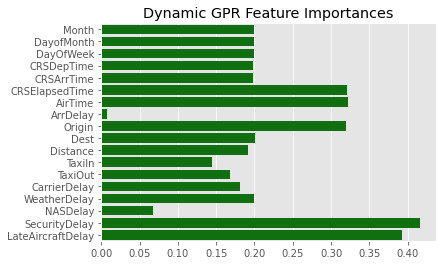

In [35]:
weight_features = [0.19983233309107076, 0.19992270235540754, 0.2000138329603557, 0.19809690932773402, 
                   0.19832393381466268, 0.32137172848695444, 0.3222712879330111, 0.0076917229589015795,
                   0.31978561739776684, 0.20100546374385522, 0.19179048432040624, 0.1446488740179604, 
                   0.16827963276567323, 0.1816455620609336, 0.20000112748770385, 0.06700939973849772, 
                   0.41635980819682694, 0.39242210610315614]

columns = X_train.columns

# Plot
sns.barplot(x = weight_features,
           y = columns,
           color = 'green')
plt.title('Dynamic GPR Feature Importances')
plt.show()

MSE on Scaled Data: 0.6909573371149198


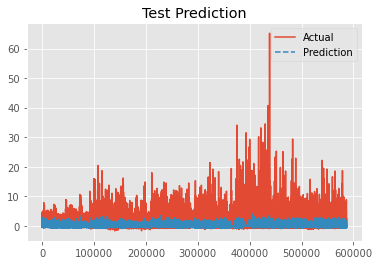

In [52]:
# Cetak nilai MSE
print('MSE on Scaled Data:', mean_squared_error(y_test_scaled.flatten(), y_pred))

# Plot prediction
idx = [i for i in range(y_test_scaled.shape[0])]
plt.plot(idx, y_test_scaled.flatten(), label = 'Actual')
plt.plot(idx, y_pred.flatten(), linestyle = '--', label = 'Prediction')
plt.title('Test Prediction')
plt.legend()
plt.show()

MSE on inverse scale data: 978.7682839339541


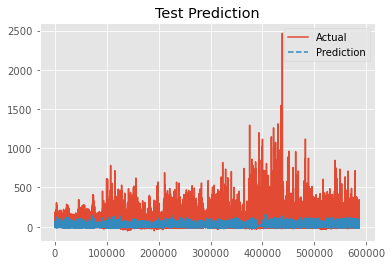

In [38]:
# Initiate Scaler
scaler = StandardScaler()

# Fit on training data
scaler.fit(np.array(y_train).reshape(-1, 1))

# Inverse Transform
y_test_inv = scaler.inverse_transform(y_test_scaled).flatten()
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Print MSE
print('MSE on inverse scale data:', mean_squared_error(y_test_inv, y_pred_inv))

# Plot prediction
idx = [i for i in range(y_test_scaled.shape[0])]
plt.plot(idx, y_test_inv, label = 'Actual')
plt.plot(idx, y_pred_inv, linestyle = '--', label = 'Prediction')
plt.title('Test Prediction')
plt.legend()
plt.show()

In [75]:
# Combine dengan date
test_data = pd.concat([test_ID, 
                       pd.Series(y_test_inv, index = test_ID.index)], axis = 1). \
            rename(columns = {0:'DepDelay'})
pred_data = pd.concat([test_ID, 
                       pd.Series(y_pred_inv, index = test_ID.index)], axis = 1). \
            rename(columns = {0:'DepDelay'})

# Lihat day of week
pred_data['dayofweek'] = pred_data['date'].dt.dayofweek
test_data['dayofweek'] = test_data['date'].dt.dayofweek

In [83]:
# Save pred_data
test_data.to_excel('Test Departure Delay.xlsx', index = False)
pred_data.to_excel('Prediction Departure Delay.xlsx', index = False)

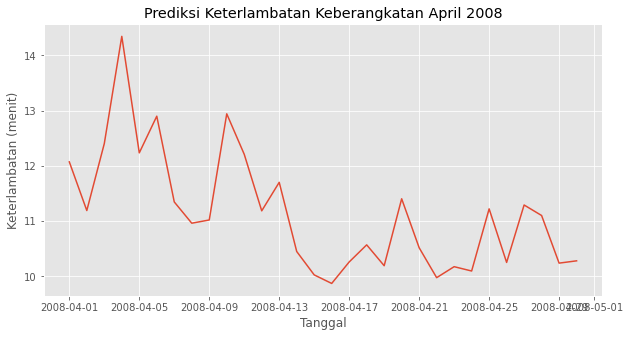

In [40]:
# Groupby date
pred_date = pred_data.groupby(['date']).agg({'DepDelay':'mean'}).reset_index()
test_date = test_data.groupby(['date']).agg({'DepDelay':'mean'}).reset_index()

# Lihat hasilnya
plt.figure(figsize = (10, 5))
plt.plot(pred_date['date'], pred_date['DepDelay'])
plt.title('Prediksi Keterlambatan Keberangkatan April 2008')
plt.xlabel('Tanggal')
plt.ylabel('Keterlambatan (menit)')
plt.show()

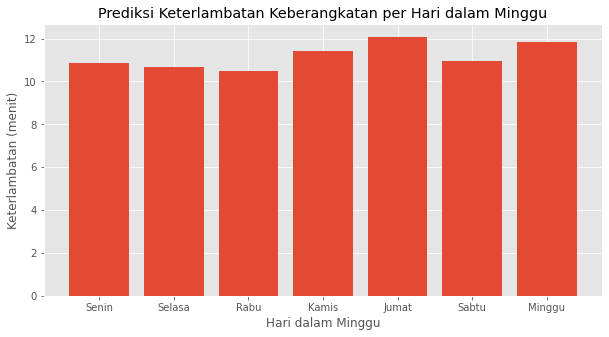

In [41]:
# Lihat day of week
pred_data['dayofweek'] = pred_data['date'].dt.dayofweek
test_data['dayofweek'] = test_data['date'].dt.dayofweek

# Groupby day of week
pred_dow = pred_data.groupby(['dayofweek']).agg({'DepDelay':'mean'}).reset_index().sort_values(by = 'dayofweek')
test_dow = test_data.groupby(['dayofweek']).agg({'DepDelay':'mean'}).reset_index().sort_values(by = 'dayofweek')

# Petakan 0-6 ke Senin - Minggu
dict_dow = {0: 'Senin',
           1: 'Selasa',
           2: 'Rabu',
           3: 'Kamis',
           4: 'Jumat',
           5: 'Sabtu',
           6: 'Minggu'}

pred_dow['dayofweek'] = pred_dow['dayofweek'].map(dict_dow)
test_dow['dayofweek'] = test_dow['dayofweek'].map(dict_dow)

# Lihat hasilnya
plt.figure(figsize = (10, 5))
plt.bar(pred_dow['dayofweek'], pred_dow['DepDelay'])
plt.title('Prediksi Keterlambatan Keberangkatan per Hari dalam Minggu')
plt.xlabel('Hari dalam Minggu')
plt.ylabel('Keterlambatan (menit)')
plt.show()

In [69]:
# Create dictionary for listed airline
airline_info = {'Southwest Airlines' :'WN',
               'JSX Air' :'XE',
               'Mesa Airlines': 'YV',
               'PSA Airlines' : 'OH',
               'SkyWest Airlines': 'OO',
               'United Airlines': 'UA',
               'US-Bangla Airlines': 'US',
               'Delta Air Lines': 'DL',
               'Eve Air Alaska': 'EV',
               'Frontier Airlines': 'F9',
               'FL':'FL',
               'Hawaiian Airlines':'HA',
               'Envoy Air':'MQ',
               'NW':'NW',
               'Endeavor Air':'9E',
               'American Airlines': 'AA',
               'Alaska Airlines': 'AS',
               'Jetblue Airways':'B6',
               'North-Western Cargo International Airlines': 'CO'}

In [80]:
# Lihat per flightcarrier
def dep_delay_prediction(carrier):
    # Map to the carrier ID
    carrier_id = airline_info[carrier]
    
    # Subset carrier
    carrier_data = pred_data[pred_data['UniqueCarrier'] == carrier_id]
    
    # Cetak informasi statistik
    print(f"Informasi Keterlambatan Maskapai {carrier}")
    print('---------------------------------------------------')
    print("Penerbangan paling terlambat dari yang dijadwalkan:")
    print(carrier_data[carrier_data['DepDelay'] == carrier_data['DepDelay'].max()])
    print("Penerbangan paling awal dari yang dijadwalkan:")
    print(carrier_data[carrier_data['DepDelay'] == carrier_data['DepDelay'].min()])
    print(f"Rerata keterlambatan: {carrier_data['DepDelay'].mean()} menit")
    
    # Groupby date
    pred_date = carrier_data.groupby(['date']).agg({'DepDelay':'mean'}).reset_index()

    # Lihat hasilnya
    plt.figure(figsize = (10, 5))
    plt.plot(pred_date['date'], pred_date['DepDelay'])
    plt.title(f'Prediksi DepDelay Maskapai {carrier} April 2008')
    plt.xlabel('Tanggal')
    plt.ylabel('Keterlambatan (menit)')
    plt.show()
    
    # Groupby day of week
    pred_dow = carrier_data.groupby(['dayofweek']).agg({'DepDelay':'mean'}).reset_index().sort_values(by = 'dayofweek')
    
    # Petakan 0-6 ke Senin - Minggu
    dict_dow = {0: 'Senin',
               1: 'Selasa',
               2: 'Rabu',
               3: 'Kamis',
               4: 'Jumat',
               5: 'Sabtu',
               6: 'Minggu'}

    pred_dow['dayofweek'] = pred_dow['dayofweek'].map(dict_dow)
    
    # Lihat hasilnya
    plt.figure(figsize = (10, 5))
    plt.bar(pred_dow['dayofweek'], pred_dow['DepDelay'])
    plt.title(f'Prediksi DepDelay Maskapai {carrier} dalam Hari')
    plt.xlabel('Hari dalam Minggu')
    plt.ylabel('Keterlambatan (menit)')
    plt.show()

Informasi Keterlambatan Maskapai Delta Air Lines
---------------------------------------------------
Penerbangan paling terlambat dari yang dijadwalkan:
              date  FlightNum UniqueCarrier TailNum Origin Dest    DepDelay  \
2373375 2008-04-04       1435            DL  N961DL    ATL  MCI  118.448377   

         dayofweek  
2373375          4  
Penerbangan paling awal dari yang dijadwalkan:
              date  FlightNum UniqueCarrier TailNum Origin Dest   DepDelay  \
2389037 2008-04-17       1032            DL  N942DL    SAV  ATL -20.176136   

         dayofweek  
2389037          3  
Rerata keterlambatan: 10.91990582723174 menit


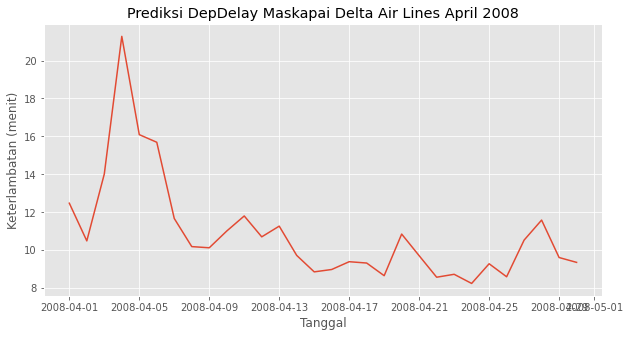

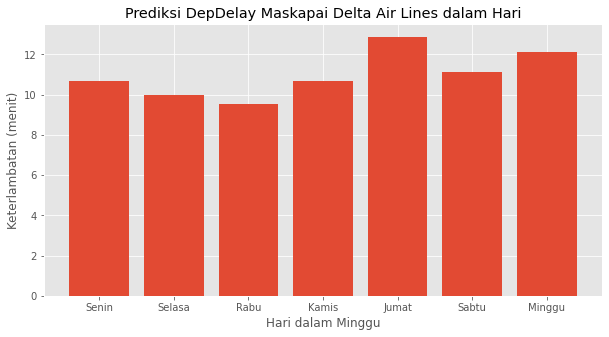

In [82]:
dep_delay_prediction('Delta Air Lines')